In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
train = pd.read_csv("jigsaw-train.csv")
dev = pd.read_csv("jigsaw-dev.csv")
test = pd.read_csv("jigsaw-test.csv")

# Part 1

### Problem 1

In [191]:
from transformers import AutoTokenizer

BASE_MODEL = "microsoft/MiniLM-L12-H384-uncased"

# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [192]:
def test_tokenize(input_word):
    return tokenizer.tokenize(input_word)

###  Problem 2 Prompt-based Learning

In [193]:
def sample_train(train,num):
    label_rows = train.drop_duplicates(subset='toxic')
    remaining_rows = train[~train.index.isin(label_rows.index)]
    sample_size = int(num)
    sample_remaining = remaining_rows.sample(n=sample_size)
    sample_train = pd.concat([label_rows, sample_remaining])
    
    return sample_train

In [194]:
def sample_dev(dev,percentage):
    label_rows = dev.drop_duplicates(subset='toxic')
    remaining_rows = dev[~dev.index.isin(label_rows.index)]
    sample_size = int(percentage * len(remaining_rows))
    sample_remaining = remaining_rows.sample(n=sample_size)
    sample_dev = pd.concat([label_rows, sample_remaining])
    
    return sample_dev

In [195]:
def get_test_fscore(ground_true, list_zero):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for i in range(len(list_zero)):

        if ground_true[i] == 1 and list_zero[i] == 1:
            true_positive = true_positive+1
        elif list_zero[i] == 1 and ground_true[i] == 0:
            false_positive = false_positive + 1
        elif list_zero[i] == 0 and ground_true[i] == 1:
            false_negative = false_negative+1
    if true_positive+false_positive == 0 or true_positive+false_negative == 0:
        return 0
    else:
        Precision = true_positive/(true_positive+false_positive)
        Recall = true_positive/(true_positive+false_negative)
        F1_Score = 2 * (Precision * Recall) / (Precision + Recall)
        return F1_Score

In [196]:
from openprompt.data_utils import InputExample
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate
from openprompt import PromptDataLoader
from openprompt.prompts import ManualVerbalizer
from openprompt import PromptForClassification
import torch

In [197]:
def get_result_few_shot(train,dev,num_train,num_dev,prompt,toxic_verb,non_toxic_verb):
    train = sample_train(train,num_train)
    train = train.reset_index()
    
    dev = sample_dev(dev,num_dev)
    dev = dev.reset_index()
    
    dataset = {}
    dataset["train"] = []
    dataset["validation"] = []
    for i in range(len(train)):
        input_example = InputExample(text_a = train["comment_text"][i], label=int(train["toxic"][i]), guid=train["id"][i])
        dataset["train"].append(input_example)

    for i in range(len(dev)):
        input_example = InputExample(text_a = dev["comment_text"][i], label=int(dev["toxic"][i]), guid=dev["id"][i])
        dataset["validation"].append(input_example)
        
    plm, tokenizer, model_config, WrapperClass = load_plm("bert", "microsoft/MiniLM-L12-H384-uncased")

    mytemplate = ManualTemplate(
        text = prompt,
        tokenizer = tokenizer,
    )

    wrapped_berttokenizer = WrapperClass(max_seq_length=128, decoder_max_length=3, tokenizer=tokenizer,truncate_method="head")


    model_inputs = {}
    model_inputs["train"] = []
    for sample in dataset["train"]:
        tokenized_example = wrapped_berttokenizer.tokenize_one_example(mytemplate.wrap_one_example(sample), teacher_forcing=False)
        model_inputs["train"].append(tokenized_example)

    train_dataloader = PromptDataLoader(dataset=dataset["train"], template=mytemplate, tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
        batch_size=4,shuffle=True, teacher_forcing=False, predict_eos_token=False,
        truncate_method="head")

    classes = [ # There are two classes in Sentiment Analysis, one for negative and one for positive
        1,
        0
    ]

    myverbalizer = ManualVerbalizer(
        classes = classes,
        num_classes = 2,
        label_words = {
            1: toxic_verb,
            0: non_toxic_verb,
        },
        tokenizer = tokenizer,
    )

    prompt_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer, freeze_plm=False)
    # Now the training is standard
    from transformers import  AdamW, get_linear_schedule_with_warmup
    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ['bias', 'LayerNorm.weight']
    # it's always good practice to set no decay to biase and LayerNorm parameters
    optimizer_grouped_parameters = [
        {'params': [p for n, p in prompt_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in prompt_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-4)

    for epoch in range(5):
        tot_loss = 0
        for step, inputs in enumerate(train_dataloader):
            logits = prompt_model(inputs)
            labels = inputs['label']
            loss = loss_func(logits, labels)
            loss.backward()
            tot_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            if step+1 %100 ==1:
                print("Epoch {}, average loss: {}".format(epoch+1, tot_loss/(step+1)), flush=True)

    # Evaluate
    validation_dataloader = PromptDataLoader(dataset=dataset["validation"], template=mytemplate, tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass, max_seq_length=256, decoder_max_length=3,
        batch_size=4,shuffle=False, teacher_forcing=False, predict_eos_token=False,
        truncate_method="head")

    allpreds = []
    alllabels = []
    for step, inputs in tqdm(enumerate(validation_dataloader)):
        logits = prompt_model(inputs)
        labels = inputs['label']
        alllabels.extend(labels.cpu().tolist())
        allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    
    f1_score = get_test_fscore(alllabels, allpreds)
    
    print(f"F1_score = {f1_score}")

#### prompt 1

In [97]:
test_tokenize("offensive")

['offensive']

In [98]:
test_tokenize("harmful")

['harmful']

In [99]:
test_tokenize("ironic")

['ironic']

In [100]:
test_tokenize("respectful")

['respectful']

In [101]:
test_tokenize("objective")

['objective']

In [102]:
test_tokenize("calm")

['calm']

In [84]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. Overall, the sentence shows {"mask"} meaning',["offensive", "harmful","ironic"],["respectful", "objective", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 645.77it/s]


Epoch 1, average loss: 0.6162680387496948
Epoch 2, average loss: 0.3228189945220947
Epoch 3, average loss: 0.11264178156852722
Epoch 4, average loss: 0.01819198951125145
Epoch 5, average loss: 0.004617789294570684


tokenizing: 3198it [00:05, 564.14it/s]
800it [01:18, 10.14it/s]

F1_score = 0.20446096654275092


In [85]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. Overall, the sentence shows {"mask"} meaning',["offensive", "harmful","ironic"],["respectful", "objective", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 441.13it/s]


Epoch 1, average loss: 0.2239687293767929
Epoch 2, average loss: 0.14414533972740173
Epoch 3, average loss: 0.11475841701030731
Epoch 4, average loss: 0.07157189399003983
Epoch 5, average loss: 0.026623627170920372


tokenizing: 3198it [00:05, 544.03it/s]
800it [01:19, 10.08it/s]


F1_score = 0.2506811989100817


In [86]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. Overall, the sentence shows {"mask"} meaning',["offensive", "harmful","ironic"],["respectful", "objective", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 577.27it/s]


Epoch 1, average loss: 1.3413636684417725
Epoch 2, average loss: 0.05031544715166092
Epoch 3, average loss: 0.03141243755817413
Epoch 4, average loss: 0.0790688544511795
Epoch 5, average loss: 1.567199945449829


tokenizing: 3198it [00:05, 550.62it/s]
800it [01:21,  9.81it/s]


F1_score = 0.3866666666666666


In [119]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. Overall, the sentence shows {"mask"} meaning',["offensive", "harmful","ironic"],["respectful", "objective", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 563.17it/s]


Epoch 1, average loss: 0.578984260559082
Epoch 2, average loss: 0.7959566712379456
Epoch 3, average loss: 0.046141717582941055
Epoch 4, average loss: 0.18834912776947021
Epoch 5, average loss: 0.0659426599740982


tokenizing: 3198it [00:05, 558.34it/s]
800it [02:06,  6.32it/s]

F1_score = 0.34615384615384615


#### prompt 2

In [89]:
test_tokenize("righteous")

['righteous']

In [120]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. The sentence contains {"mask"} content.',["offensive", "harmful", "ironic"],["respectful", "objective", "righteous"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 688.83it/s]


Epoch 1, average loss: 1.011290431022644
Epoch 2, average loss: 0.5768179297447205
Epoch 3, average loss: 0.481148898601532
Epoch 4, average loss: 0.7684519290924072
Epoch 5, average loss: 0.18186447024345398


tokenizing: 3198it [00:05, 545.37it/s]
800it [01:48,  7.38it/s]

F1_score = 0.21662852784134246


In [168]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. The sentence contains {"mask"} content.',["offensive", "harmful", "ironic"],["respectful", "objective", "righteous"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 441.44it/s]


Epoch 1, average loss: 0.6349068880081177
Epoch 2, average loss: 1.127171277999878
Epoch 3, average loss: 0.5463032722473145
Epoch 4, average loss: 0.07323082536458969
Epoch 5, average loss: 0.00214298814535141


tokenizing: 3198it [00:06, 515.08it/s]
800it [01:11, 11.17it/s]


F1_score = 0.3093333333333333


In [122]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. The sentence contains {"mask"} content.',["offensive", "harmful", "ironic"],["respectful", "objective", "righteous"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 631.53it/s]


Epoch 1, average loss: 0.44197627902030945
Epoch 2, average loss: 0.009867089800536633
Epoch 3, average loss: 0.10777536779642105
Epoch 4, average loss: 0.002364066196605563
Epoch 5, average loss: 0.0007725008763372898


tokenizing: 3198it [00:06, 503.59it/s]
800it [01:54,  6.96it/s]

F1_score = 0.40404040404040403


In [123]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. The sentence contains {"mask"} content.',["offensive", "harmful", "ironic"],["respectful", "objective", "righteous"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 514.11it/s]


Epoch 1, average loss: 0.704562246799469
Epoch 2, average loss: 0.07814618945121765
Epoch 5, average loss: 0.0024189259856939316


tokenizing: 3198it [00:06, 526.91it/s]
800it [01:50,  7.25it/s]

F1_score = 0.6000000000000001


#### prompt 3

In [90]:
test_tokenize("dismiss")

['dismiss']

In [91]:
test_tokenize("blame")

['blame']

In [92]:
test_tokenize("discourage")

['discourage']

In [95]:
test_tokenize("respect")

['respect']

In [94]:
test_tokenize("praise")

['praise']

In [103]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. The sentence contents {"mask"} others.',["dismiss", "blame", "discourage"],["respect", "praise"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 717.40it/s]


Epoch 1, average loss: 0.48932814598083496
Epoch 2, average loss: 1.0996630191802979
Epoch 3, average loss: 0.15091800689697266
Epoch 4, average loss: 0.044643957167863846
Epoch 5, average loss: 0.0014356172177940607


tokenizing: 3198it [00:05, 543.50it/s]
800it [01:17, 10.38it/s]

F1_score = 0.24747474747474746


In [104]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. The sentence contents {"mask"} others.',["dismiss", "blame", "discourage"],["respect", "praise"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 584.26it/s]


Epoch 1, average loss: 0.47104278206825256
Epoch 2, average loss: 0.005094663240015507
Epoch 3, average loss: 0.23470842838287354
Epoch 4, average loss: 1.2547142505645752
Epoch 5, average loss: 0.0026776036247611046


tokenizing: 3198it [00:05, 556.77it/s]
800it [01:13, 10.93it/s]


F1_score = 0.37104072398190047


In [124]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. The sentence contents {"mask"} others.',["dismiss", "blame", "discourage"],["respect", "praise"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 488.87it/s]


Epoch 1, average loss: 0.4631975293159485
Epoch 2, average loss: 0.09632903337478638
Epoch 3, average loss: 0.04812886565923691
Epoch 4, average loss: 0.00028987418045289814
Epoch 5, average loss: 0.06535186618566513


tokenizing: 3198it [00:05, 543.16it/s]
800it [01:51,  7.19it/s]

F1_score = 0.4080604534005038


In [111]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. The sentence contains {"mask"} content.',["dismiss", "blame", "discourage"],["respect", "praise"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 536.70it/s]


Epoch 1, average loss: 1.8510665893554688
Epoch 2, average loss: 1.3272705078125
Epoch 3, average loss: 0.3245682716369629
Epoch 4, average loss: 0.05697108060121536
Epoch 5, average loss: 0.008411637507379055


tokenizing: 3198it [00:05, 567.06it/s]
800it [01:20,  9.95it/s]

F1_score = 0.5338983050847457


#### prompt 4

In [112]:
test_tokenize("angry")

['angry']

In [113]:
test_tokenize("peaceful")

['peaceful']

In [114]:
test_tokenize("discouraged")

['discouraged']

In [115]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. If I hear the words above I will be {"mask"}.',["angry", "depressed", "discouraged"],["peaceful", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 705.12it/s]


Epoch 1, average loss: 0.47519469261169434
Epoch 2, average loss: 0.0248589925467968
Epoch 3, average loss: 0.03397197648882866
Epoch 4, average loss: 0.03964041545987129
Epoch 5, average loss: 0.013737921603024006


tokenizing: 3198it [00:06, 527.25it/s]
800it [01:15, 10.53it/s]

F1_score = 0.26616915422885573


In [116]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. If I hear the words above I will be {"mask"}.',["angry", "depressed", "discouraged"],["peaceful", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 419.35it/s]


Epoch 1, average loss: 0.592880368232727
Epoch 2, average loss: 0.7842541933059692
Epoch 3, average loss: 0.5422950387001038
Epoch 4, average loss: 0.9736071228981018
Epoch 5, average loss: 0.03192504495382309


tokenizing: 3198it [00:05, 550.89it/s]
800it [01:23,  9.59it/s]


F1_score = 0.35714285714285715


In [117]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. If I hear the words above I will be {"mask"}.',["angry", "depressed", "discouraged"],["peaceful", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 543.92it/s]


Epoch 1, average loss: 0.3383324444293976
Epoch 2, average loss: 0.15238425135612488
Epoch 3, average loss: 0.5374076962471008
Epoch 4, average loss: 0.08589183539152145
Epoch 5, average loss: 0.1812836229801178


tokenizing: 3198it [00:05, 547.94it/s]
800it [01:17, 10.26it/s]


F1_score = 0.47259658580413305


In [198]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. If I hear the words above I will be {"mask"}.',["angry", "depressed", "discouraged"],["peaceful", "calm"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 584.80it/s]


Epoch 1, average loss: 0.6921087503433228
Epoch 2, average loss: 0.19223040342330933
Epoch 3, average loss: 0.07272006571292877
Epoch 4, average loss: 0.7247632741928101
Epoch 5, average loss: 0.0789065957069397


tokenizing: 3198it [00:05, 542.67it/s]
800it [01:36,  8.25it/s]


F1_score = 0.5513698630136987


#### prompt 5

In [107]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. The person who said the sentence above is {"mask"}.',["angry", "ironic", "offensive"],["peaceful", "calm", "kind"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 577.82it/s]


Epoch 1, average loss: 0.35602301359176636
Epoch 2, average loss: 1.2343670129776
Epoch 3, average loss: 0.28149446845054626
Epoch 4, average loss: 0.02452394738793373
Epoch 5, average loss: 0.009508439339697361


tokenizing: 3198it [00:06, 531.15it/s]
800it [01:18, 10.13it/s]

F1_score = 0.08488063660477453


In [108]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. The person who said the sentence above is {"mask"}.',["angry", "ironic", "offensive"],["peaceful", "calm", "kind"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 592.77it/s]


Epoch 1, average loss: 0.9092667102813721
Epoch 2, average loss: 0.12530800700187683
Epoch 3, average loss: 0.024530034512281418
Epoch 4, average loss: 0.07548309117555618
Epoch 5, average loss: 0.539513111114502


tokenizing: 3198it [00:05, 538.19it/s]
800it [01:13, 10.94it/s]

F1_score = 0.4


In [169]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. The person who said the sentence above is {"mask"}.',["angry", "ironic", "offensive"],["peaceful", "calm", "kind"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 577.45it/s]


Epoch 1, average loss: 0.5781936049461365
Epoch 2, average loss: 0.13281819224357605
Epoch 3, average loss: 0.055844131857156754
Epoch 4, average loss: 0.01884298026561737
Epoch 5, average loss: 0.03556939214468002


tokenizing: 3198it [00:05, 542.24it/s]
800it [01:16, 10.43it/s]


F1_score = 0.334140435835351


In [110]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. The person who said the sentence above is {"mask"}.',["angry", "ironic", "offensive"],["peaceful", "calm", "kind"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 539.88it/s]


Epoch 1, average loss: 0.5446164608001709
Epoch 2, average loss: 0.5870131254196167
Epoch 3, average loss: 0.06619705259799957
Epoch 4, average loss: 0.012930629774928093
Epoch 5, average loss: 0.00043522552005015314


tokenizing: 3198it [00:05, 540.02it/s]
800it [01:14, 10.70it/s]


F1_score = 0.5681818181818181


#### prompt 6

In [126]:
test_tokenize("enemies")

['enemies']

In [129]:
test_tokenize("friends")

['friends']

In [128]:
test_tokenize("lovers")

['lovers']

In [127]:
test_tokenize("rivals")

['rivals']

In [141]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. The most likely context for the above conversation to occur is between {"mask"}.',["enemies", "rivals"],["friends", "lovers"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 371.68it/s]


Epoch 1, average loss: 0.5810356736183167
Epoch 2, average loss: 0.03409521281719208
Epoch 3, average loss: 0.017923492938280106
Epoch 4, average loss: 0.04713040590286255
Epoch 5, average loss: 0.002651273738592863


tokenizing: 3198it [00:06, 484.35it/s]
800it [01:33,  8.52it/s]


F1_score = 0.13513513513513514


In [205]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. The most likely context for the above conversation to occur is between {"mask"}.',["enemies", "rivals"],["friends", "lovers"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 408.22it/s]


Epoch 1, average loss: 0.16565179824829102
Epoch 2, average loss: 0.008617420680820942
Epoch 3, average loss: 0.01848594844341278
Epoch 4, average loss: 0.0009608943946659565
Epoch 5, average loss: 7.21482647350058e-05


tokenizing: 3198it [00:06, 529.13it/s]
800it [01:26,  9.23it/s]


F1_score = 0.22905027932960897


In [199]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. The most likely context for the above conversation to occur is between {"mask"}.',["enemies", "rivals"],["friends", "lovers"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 512.48it/s]


Epoch 1, average loss: 0.9539127349853516
Epoch 2, average loss: 0.09713759273290634
Epoch 3, average loss: 0.010436358861625195
Epoch 4, average loss: 0.01777103915810585
Epoch 5, average loss: 0.055023666471242905


tokenizing: 3198it [00:06, 525.32it/s]
800it [01:27,  9.13it/s]


F1_score = 0.47265625000000006


In [144]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. The most likely context for the above conversation to occur is between {"mask"}.',["enemies", "rivals"],["friends", "lovers"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 535.95it/s]


Epoch 1, average loss: 0.8201795816421509
Epoch 2, average loss: 0.09026548266410828
Epoch 3, average loss: 0.016530165448784828
Epoch 4, average loss: 0.029234305024147034


tokenizing: 3198it [00:06, 498.27it/s]
800it [01:32,  8.65it/s]


F1_score = 0.565410199556541


#### prompt 7

In [133]:
test_tokenize("crime")

['crime']

In [135]:
test_tokenize("documentary")

['documentary']

In [134]:
test_tokenize("war")

['war']

In [136]:
test_tokenize("children")

['children']

In [140]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. The above statement is most likely to occur in a movie belonging to the {"mask"} genre.',["crime", "war"],["documentary", "children"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 540.09it/s]


Epoch 1, average loss: 0.5498024225234985
Epoch 2, average loss: 0.9563628435134888
Epoch 3, average loss: 0.6177759766578674
Epoch 4, average loss: 0.42028263211250305
Epoch 5, average loss: 0.3444255590438843


tokenizing: 3198it [00:06, 509.98it/s]
800it [01:46,  7.52it/s]

F1_score = 0.22182468694096602


In [137]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. The above statement is most likely to occur in a movie belonging to the {"mask"} genre.',["crime", "war"],["documentary", "children"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 475.83it/s]


Epoch 1, average loss: 2.644014835357666
Epoch 2, average loss: 0.01988140121102333
Epoch 3, average loss: 0.12491446733474731
Epoch 4, average loss: 0.055638253688812256
Epoch 5, average loss: 0.6645469069480896


tokenizing: 3198it [00:06, 483.59it/s]
800it [01:34,  8.46it/s]

F1_score = 0.36853448275862066


In [138]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. The above statement is most likely to occur in a movie belonging to the {"mask"} genre.',["crime", "war"],["documentary", "children"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 427.85it/s]


Epoch 1, average loss: 0.669137716293335
Epoch 2, average loss: 0.28149276971817017
Epoch 3, average loss: 0.01632738672196865
Epoch 4, average loss: 0.004149508196860552
Epoch 5, average loss: 0.0015196979511529207


tokenizing: 3198it [00:06, 498.30it/s]
800it [01:29,  8.95it/s]


F1_score = 0.5047318611987383


In [139]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. The above statement is most likely to occur in a movie belonging to the {"mask"} genre.',["crime", "war"],["documentary", "children"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 527.48it/s]


Epoch 1, average loss: 0.6665509343147278
Epoch 2, average loss: 0.1740700751543045
Epoch 3, average loss: 0.531547486782074
Epoch 4, average loss: 0.6191444993019104
Epoch 5, average loss: 0.03877025842666626


tokenizing: 3198it [00:06, 498.91it/s]
800it [01:43,  7.73it/s]

F1_score = 0.4891774891774892


#### prompt 8

In [148]:
test_tokenize("yes")

['yes']

In [147]:
test_tokenize("no")

['no']

In [146]:
test_tokenize("absolutely")

['absolutely']

In [145]:
test_tokenize("unlikely")

['unlikely']

In [150]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. Do you think a gentle and easygoing person would say the above statement? Answer: {"mask"}.',["no", "unlikely"],["yes", "absolutely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 722.69it/s]


Epoch 1, average loss: 0.9162700772285461
Epoch 2, average loss: 0.6909216642379761
Epoch 3, average loss: 0.2883400321006775
Epoch 4, average loss: 0.6308941841125488
Epoch 5, average loss: 0.14249205589294434


tokenizing: 3198it [00:06, 510.35it/s]
800it [01:34,  8.49it/s]

F1_score = 0.11389521640091116


In [151]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. Do you think a gentle and easygoing person would say the above statement? Answer: {"mask"}.',["no", "unlikely"],["yes", "absolutely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 413.43it/s]


Epoch 1, average loss: 0.5275701284408569
Epoch 2, average loss: 0.867324709892273
Epoch 3, average loss: 1.5586776733398438
Epoch 4, average loss: 0.08562132716178894
Epoch 5, average loss: 0.11206943541765213


tokenizing: 3198it [00:06, 501.96it/s]
800it [01:39,  8.08it/s]


F1_score = 0.16400911161731208


In [152]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. Do you think a gentle and easygoing person would say the above statement? Answer: {"mask"}.',["no", "unlikely"],["yes", "absolutely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 440.84it/s]


Epoch 1, average loss: 0.6388476490974426
Epoch 2, average loss: 0.05183045566082001
Epoch 3, average loss: 0.15265856683254242
Epoch 4, average loss: 0.09920595586299896
Epoch 5, average loss: 0.0007755099795758724


tokenizing: 3198it [00:06, 487.76it/s]
800it [01:32,  8.70it/s]

F1_score = 0.555746140651801


In [153]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. Do you think a gentle and easygoing person would say the above statement? Answer: {"mask"}.',["no", "unlikely"],["yes", "absolutely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 505.68it/s]


Epoch 1, average loss: 1.0261898040771484
Epoch 2, average loss: 0.2037329226732254
Epoch 3, average loss: 0.046645134687423706
Epoch 4, average loss: 0.042868345975875854
Epoch 5, average loss: 0.23403549194335938


tokenizing: 3198it [00:06, 498.27it/s]
800it [01:43,  7.73it/s]


F1_score = 0.48484848484848486


#### prompt 9

In [171]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. Do you think a angry and offensive person would say the above statement? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 586.71it/s]


Epoch 1, average loss: 1.3347258567810059
Epoch 2, average loss: 1.0625371932983398
Epoch 3, average loss: 0.6823068261146545
Epoch 4, average loss: 0.41421106457710266
Epoch 5, average loss: 0.21459876000881195


tokenizing: 3198it [00:06, 523.23it/s]
800it [01:17, 10.30it/s]

F1_score = 0.21558872305140964


In [206]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. Do you think a angry and offensive person would say the above statement? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 514.77it/s]


Epoch 1, average loss: 0.641349732875824
Epoch 2, average loss: 0.5798465013504028
Epoch 3, average loss: 0.34467339515686035
Epoch 4, average loss: 0.898923933506012
Epoch 5, average loss: 0.3761307895183563


tokenizing: 3198it [00:06, 481.17it/s]
800it [01:29,  8.94it/s]


F1_score = 0.1388888888888889


In [161]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. Do you think a angry and offensive person would say the above statement? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 464.14it/s]


Epoch 1, average loss: 0.91446852684021
Epoch 2, average loss: 0.009039508178830147
Epoch 3, average loss: 0.021195389330387115
Epoch 4, average loss: 0.14902044832706451
Epoch 5, average loss: 0.002520659239962697


tokenizing: 3198it [00:06, 495.86it/s]
800it [01:16, 10.41it/s]

F1_score = 0.4505747126436782


In [162]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. Do you think a angry and offensive person would say the above statement? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:00, 518.77it/s]


Epoch 1, average loss: 0.5005200505256653
Epoch 2, average loss: 0.03772956132888794
Epoch 3, average loss: 0.0039591193199157715
Epoch 4, average loss: 0.0034470194950699806
Epoch 5, average loss: 0.0002812637249007821


tokenizing: 3198it [00:06, 473.03it/s]
800it [01:19, 10.03it/s]


F1_score = 0.5612788632326821


#### prompt 10

In [164]:
get_result_few_shot(train,dev,10,0.1,'{"placeholder":"text_a"}. Do you think the sentence above is a toxic sentence? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 12it [00:00, 716.93it/s]


Epoch 1, average loss: 0.8131697177886963
Epoch 2, average loss: 0.5786397457122803
Epoch 3, average loss: 0.2135779857635498
Epoch 4, average loss: 0.18650028109550476
Epoch 5, average loss: 0.11052042245864868


tokenizing: 3198it [00:06, 523.31it/s]
800it [01:14, 10.70it/s]


F1_score = 0.19815668202764977


In [204]:
get_result_few_shot(train,dev,50,0.1,'{"placeholder":"text_a"}. Do you think the sentence above is a toxic sentence? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 52it [00:00, 463.19it/s]


Epoch 1, average loss: 0.7112749218940735
Epoch 2, average loss: 0.16376329958438873
Epoch 3, average loss: 0.008568543940782547
Epoch 4, average loss: 0.013852277770638466
Epoch 5, average loss: 0.6061021685600281


tokenizing: 3198it [00:06, 526.43it/s]
800it [01:27,  9.15it/s]

F1_score = 0.2280701754385965


In [201]:
get_result_few_shot(train,dev,100,0.1,'{"placeholder":"text_a"}. Do you think the sentence above is a toxic sentence? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 102it [00:00, 563.54it/s]


Epoch 1, average loss: 1.0562331676483154
Epoch 2, average loss: 0.5127506256103516
Epoch 3, average loss: 0.6376174092292786
Epoch 4, average loss: 0.21327121555805206
Epoch 5, average loss: 0.8810306787490845


tokenizing: 3198it [00:05, 544.15it/s]
800it [01:29,  8.94it/s]

F1_score = 0.5799701046337817


In [202]:
get_result_few_shot(train,dev,500,0.1,'{"placeholder":"text_a"}. Do you think the sentence above is a toxic sentence? Answer: {"mask"}.',["yes", "absolutely"], ["no", "unlikely"])


Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
tokenizing: 502it [00:01, 473.99it/s]


Epoch 1, average loss: 1.9974207878112793
Epoch 2, average loss: 0.7317872643470764
Epoch 3, average loss: 0.00904694851487875
Epoch 4, average loss: 0.01579928770661354
Epoch 5, average loss: 0.00499735539779067


tokenizing: 3198it [00:05, 536.30it/s]
800it [01:28,  9.09it/s]


F1_score = 0.5293586269196026


### Problem 3 Zero-shot Learning with small model for dev dataset

In [33]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")

In [34]:
def inference(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids, max_length=200, bos_token_id=0)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result

In [35]:
dev.head()

,id,comment_text,toxic
0,392f6ca96a17f3ea,"Using payscale.com, salaries for veterinarians...",0
1,514e6388188c8578,"""of the toxins used in zombification? If so, I...",0
2,ecaf26f6a2e2ad16,:I just did some poking around Open Group's we...,0
3,b810426156c0d0d3,Barnstorming from Activision is the original r...,0
4,40d1086bdb2a1b85,"|listas= Mommers, Hendrick",0


In [89]:
def get_new(row):
    row["comment_text"] = "<" + row["comment_text"] + ">"
    return row

new_dev = dev.apply(get_new,axis="columns")

In [91]:
#Using 10% for each training
def get_part_new_dev(new_dev,percentage):
    label_rows = new_dev.drop_duplicates(subset='toxic')
    remaining_rows = new_dev[~new_dev.index.isin(label_rows.index)]
    sample_size = int(percentage * len(remaining_rows))
    sample_remaining = remaining_rows.sample(n=sample_size)
    sample_dev = pd.concat([label_rows, sample_remaining])
    
    return sample_dev

In [92]:
def get_test_fscore(ground_true, list_zero):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for i in range(len(list_zero)):

        if ground_true[i] == 1 and list_zero[i] == 1:
            true_positive = true_positive+1
        elif list_zero[i] == 1 and ground_true[i] == 0:
            false_positive = false_positive + 1
        elif list_zero[i] == 0 and ground_true[i] == 1:
            false_negative = false_negative+1
    if true_positive+false_positive == 0 or true_positive+false_negative == 0:
        return 0
    else:
        Precision = true_positive/(true_positive+false_positive)
        Recall = true_positive/(true_positive+false_negative)
        F1_Score = 2 * (Precision * Recall) / (Precision + Recall)
        return F1_Score

In [93]:
def get_result_dev(new_dev,prompt):
    list_zero = []
    new_dev = get_part_new_dev(new_dev,0.1)
    new_dev = new_dev.reset_index()
    for i in tqdm(range(len(new_dev))):
        input_text = new_dev["comment_text"][i] + prompt
        result = inference(input_text)
        try:
            list_zero.append(int(result))
        except:
            list_zero.append(0)
    
    ground_true = new_dev["toxic"].tolist()
    
    f1_score = get_test_fscore(ground_true, list_zero)
    
    return f1_score

In [94]:
get_result_dev(new_dev,"Please determine whether the sentence in <> is a offensive or hurtful sentence, If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [05:07<00:00, 10.41it/s] 


0.17845961177207265

In [95]:
get_result_dev(new_dev,"Please determine whether the sentence in <> dismisses or invalidates someone's feelings or experiences, If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [06:18<00:00,  8.44it/s] 


0.19701699618453

In [103]:
get_result_dev(new_dev,"Please determine whether the sentence in <> is just a plain description without strong emotional color. If so, return 0; if not, return 1")


100%|██████████| 3198/3198 [05:02<00:00, 10.56it/s] 


0

In [105]:
get_result_dev(new_dev,"Please determine whether the sentence in <> made by a person with criminal tendencies, If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [04:29<00:00, 11.86it/s] 


0.18204106650321789

In [106]:
get_result_dev(new_dev,"Please determine whether the sentence in <> would be said by a genteel person., If so, return 0; if not, return 1")


100%|██████████| 3198/3198 [05:50<00:00,  9.12it/s]


0

In [113]:
get_result_dev(new_dev,"Please determine whether the sentence in <> will blame someone and make them unhappy. If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [05:09<00:00, 10.35it/s]


0.16146645865834633

In [108]:
get_result_dev(new_dev,"Please determine whether people would become angry or discouraged after hearing the sentence in <>. If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [03:40<00:00, 14.48it/s]


0.17207792207792208

In [109]:
get_result_dev(new_dev,"Please determine whether the content in <> is more likely to be said by a person with a bad temper. If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [04:55<00:00, 10.83it/s]


0.1798463624039765

In [110]:
get_result_dev(new_dev,"Please determine whether the sentence in <> is a toxic sentence, If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [06:00<00:00,  8.87it/s]


0.20331186752529898

In [111]:
get_result_dev(new_dev,"Please determine whether the sentence in <> would cause tension in the relationship between people., If so, return 1; if not, return 0")


100%|██████████| 3198/3198 [05:54<00:00,  9.03it/s]


0.15384615384615383

### Problem 3 Zero-shot Learning with small model for test dataset

In [112]:
#I will use the prompt got the highest F1 score before.

In [127]:
test.head()

,id,comment_text
0,d9836e25d089cab8,<I suggest you add this to the LARPA wiki inst...
1,3fbed19498484f71,"<, 19 May 2008 (UTC) \n ::The AFD is truly sad..."
2,be887f0617e43898,"<===Train name, misnomer=== \n The problem is ..."
3,ddb1781c5174e079,<March 2006>
4,6f04966e1d4d2b61,<unfair warnings as threats>


In [128]:
def get_new(row):
    row["comment_text"] = "<" + row["comment_text"] + ">"
    return row


new_test_zero_shot = test.apply(get_new,axis="columns")

In [129]:
list_zero_test = []
for i in tqdm(range(len(new_test_zero_shot))):
    input_text = new_test_zero_shot["comment_text"][i] + "Please determine whether the sentence in <> is a toxic sentence. If so, return 1; if not, return 0"
    result = inference(input_text)
    try:
        list_zero_test.append(int(result))
    except:
        list_zero_test.append(0)


100%|██████████| 32009/32009 [45:03<00:00, 11.84it/s]  


In [130]:
zero_shot_result2 = test.assign(toxic = list_zero_test)

In [131]:
zero_shot_result2.to_csv("zero_shot_result.csv",index = False)

In [132]:
zero_shot_result2

,id,comment_text,toxic
0,d9836e25d089cab8,<<I suggest you add this to the LARPA wiki ins...,0
1,3fbed19498484f71,"<<, 19 May 2008 (UTC) \n ::The AFD is truly sa...",1
2,be887f0617e43898,"<<===Train name, misnomer=== \n The problem is...",1
3,ddb1781c5174e079,<<March 2006>>,0
4,6f04966e1d4d2b61,<<unfair warnings as threats>>,0
...,...,...,...
32004,22abb35000de7828,<<== Motion Picture Association of America fil...,0
32005,834fd790ecbcf68f,"<<"" \n\n ==WikiProject Pharmacology Update== \...",1
32006,76417c0f552a71b2,<<That's nonsense. Most lists of Jews explicit...,0
32007,6c7c337a97b1d905,<<==References== \n Removed Youtube link to V-...,1


### Problem 4

In [3]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import torch
import numpy as np

In [4]:
train_dataset = pd.read_csv("jigsaw-train.csv")
eval_dataset = pd.read_csv("jigsaw-dev.csv")

train_dataset = train_dataset[["comment_text","toxic"]]
eval_dataset = eval_dataset[["comment_text","toxic"]]

train_dataset = train_dataset.rename(columns={'comment_text': 'text', 'toxic': 'score'})
eval_dataset = eval_dataset.rename(columns={'comment_text': 'text', 'toxic': 'score'})

In [5]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "microsoft/MiniLM-L12-H384-uncased"
LEARNING_RATE = 1e-2
MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 2

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
ds = {"train": train_dataset, "test": eval_dataset}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/31969 [00:00<?, ? examples/s]

In [48]:
# import numpy as np
# from datasets import load_metric

# metric = load_metric("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)  

In [8]:
from datasets import load_metric
metric1 = load_metric("precision")
metric2 = load_metric("recall")
metric3 = load_metric("f1")
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels)["precision"]
    recall = metric2.compute(predictions=predictions, references=labels)["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels)["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

/tmp/ipykernel_1143549/2226873423.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("precision")


In [9]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="SI630",  # output directory
    learning_rate=1e-5,
    num_train_epochs=2,  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,  # batch size for evaluation
    weight_decay=0.01,  # strength of weight decay
    do_eval=True,
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=2000,
)

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/home/kuminia/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
2000,0.141200,0.280085,0.545512,0.842741,0.662308,0.917608
4000,0.128200,0.267898,0.586301,0.843393,0.691731,0.927930
6000,0.135900,0.266887,0.524741,0.909951,0.665632,0.912353
8000,0.124300,0.254966,0.586792,0.858075,0.696966,0.928462
10000,0.133900,0.397090,0.490220,0.932137,0.642528,0.900560
12000,0.121400,0.314745,0.507254,0.923980,0.654949,0.906660
14000,0.119300,0.325791,0.571398,0.873409,0.690839,0.925052
16000,0.111100,0.275711,0.544204,0.903752,0.679338,0.918202
18000,0.101000,0.339006,0.557743,0.896574,0.687688,0.921924
20000,0.106300,0.321301,0.541323,0.921044,0.681884,0.917608


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=39894, training_loss=0.11436075472667975, metrics={'train_runtime': 4352.6899, 'train_samples_per_second': 73.321, 'train_steps_per_second': 9.165, 'total_flos': 1.0511377416701952e+16, 'train_loss': 0.11436075472667975, 'epoch': 2.0})

In [11]:
trainer.evaluate()

{'eval_loss': 0.31719914078712463,
 'eval_precision': 0.5514632689627712,
 'eval_recall': 0.9037520391517129,
 'eval_f1': 0.684965380811078,
 'eval_accuracy': 0.9202977884825925,
 'eval_runtime': 74.6501,
 'eval_samples_per_second': 428.251,
 'eval_steps_per_second': 53.543,
 'epoch': 2.0}

## Plot and conclusion

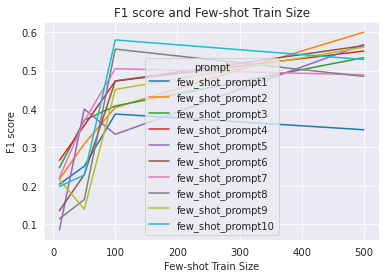

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

few_shot_train_size = [10,50,100,500]
few_shot_prompt1 = [0.204,0.251,0.387,0.346]
few_shot_prompt2 = [0.217,0.309,0.404,0.6]
few_shot_prompt3 = [0.247,0.371,0.408,0.534]
few_shot_prompt4 = [0.266,0.357,0.473,0.551]
few_shot_prompt5 = [0.085,0.4,0.334,0.568]
few_shot_prompt6 = [0.135,0.229,0.473,0.565]
few_shot_prompt7 = [0.222,0.369,0.505,0.489]
few_shot_prompt8 = [0.114,0.164,0.556,0.485]
few_shot_prompt9 = [0.216,0.139,0.451,0.561]
few_shot_prompt10 = [0.198,0.228,0.58,0.529]

df = pd.DataFrame({
    "few_shot_train_size": few_shot_train_size,
    "few_shot_prompt1": few_shot_prompt1,
    "few_shot_prompt2": few_shot_prompt2,
    "few_shot_prompt3": few_shot_prompt3,
    "few_shot_prompt4": few_shot_prompt4,
    "few_shot_prompt5": few_shot_prompt5,
    "few_shot_prompt6": few_shot_prompt6,
    "few_shot_prompt7": few_shot_prompt7,
    "few_shot_prompt8": few_shot_prompt8,
    "few_shot_prompt9": few_shot_prompt9,
    "few_shot_prompt10": few_shot_prompt10,
})

df_melted = pd.melt(df, id_vars="few_shot_train_size", var_name="prompt", value_name="F1 score")

sns.lineplot(x="few_shot_train_size", y="F1 score", hue="prompt", data=df_melted)

plt.title("F1 score and Few-shot Train Size")
plt.xlabel("Few-shot Train Size")
plt.ylabel("F1 score")

plt.show()

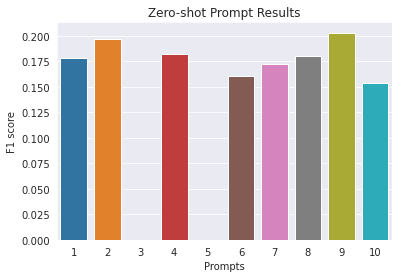

In [19]:
sns.set_style("darkgrid")

prompts = range(1,11)
zero_shot_prompts_result = [0.178,0.197,0,0.182,0,0.161,0.172,0.18,0.203,0.154]

df = pd.DataFrame({
    "prompts": prompts,
    "zero_shot_prompts_result": zero_shot_prompts_result,
})

sns.barplot(x="prompts", y="zero_shot_prompts_result", data=df)

plt.title("Zero-shot Prompt Results")
plt.xlabel("Prompts")
plt.ylabel("F1 score")

plt.show()

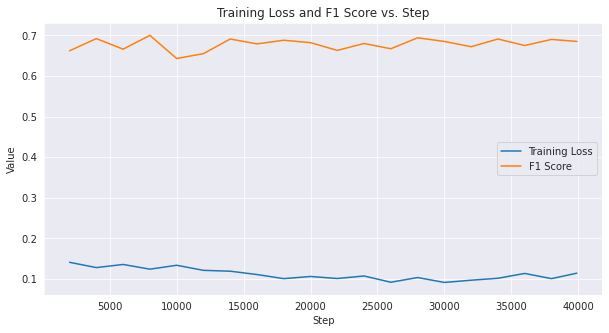

In [49]:
sns.set_style("darkgrid")

step = list(range(2000, 40000, 2000))
step.append(39894)
Training_Loss = [0.1412,0.1282,0.1359,0.1243,0.1339,0.1214,0.1193,0.1111,0.101,0.1063,0.1013,0.1075,0.0921,0.1037,0.0916,0.0971,0.1019,0.1138,0.101,0.1144]
F1_score = [0.662,0.692,0.666,0.7,0.643,0.655,0.691,0.679,0.688,0.682,0.663,0.680,0.667,0.694,0.685,0.672,0.691,0.675,0.690,0.685]

data = {'step': step,
        'Training Loss': Training_Loss,
        'F1 Score': F1_score}

df = pd.DataFrame(data)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, x='step', y='Training Loss', ax=ax, label='Training Loss')
sns.lineplot(data=df, x='step', y='F1 Score', ax=ax, label='F1 Score')
ax.set(xlabel='Step', ylabel='Value', title='Training Loss and F1 Score vs. Step')
plt.show()
